# **Introduction**

Convolutional Neural Networks (CNNs), originally invented for computer vision, have been shown to achieve strong performance on text classification tasks (Bai et al., 2018; Kalchbrenner et al., 2014; Wang et al., 2015; Zhang et al., 2015; Johnson and Zhang, 2015; Iyyer et al., 2015) as well as other traditional Natural Language Processing (NLP) tasks (Collobert et al., 2011), even when considering relatively simple one-layer models (Kim, 2014).
As with other architectures of neural networks, explaining the learned functionality of CNNs is still an active research area. The ability to interpret neural models can be used to increase trust in model predictions, analyze errors or improve the model (Ribeiro et al., 2016). 
In this assignment we’re supposed to classify the imdb movie reviews dataset as a positive or negative reviews. The work will be divided into 3 parts:

- Data preprocessing: which is mainly about getting the data ready to be processed my our model
- Defining the model : implementing the “vanilla” model 
- Optimization of the architecture: performing Grid-Search of several meta-parameters and hyper-parameters

In [ ]:
import nltk
nltk.download('punkt')
import os
import re
import io
import string
import pandas as pd
from nltk import word_tokenize
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models
from keras.preprocessing import sequence
from keras.preprocessing import text
from keras.models import Sequential
from keras.layers import  Activation
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.merge import concatenate
from tensorflow import keras

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sebastian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


###Importing the csv file when using google colab

In [ ]:
from google.colab import files
uploaded = files.upload()
file = io.BytesIO(uploaded['review_samples.csv'])

###Importing the file when running the notebook on your PC (has to be in the same directory).

In [ ]:
file = './review_samples.csv'
print(file)

./review_samples.csv


# **Implementation**

## 1. Data Processing:

Before we implement the CNN vanilla model we must first do some preprocessing on the dataset to make it suitable for the training of our model. We do that with the function **clean_text()** that takes the whole dataset as an input and preform the following tasks: 

- Change the text of each to lowercase 
- Changing each digit occurence with the symbol "#"
- Delete the line break tags
- Find all the emojis
- Tokenize the text
- Concetenate the cleaned text with the emojis

These tasks are done for each review of our imdb dataset, so the function returns the preprocessed dataset. Next step is to split the dataset into 3 subsets; training set, testing set and a validation set with sizes (32000, 10000, 8000) reviews respectively. 

In [ ]:
def clean_text(text):
        cleaned_dataframe = text['review']
        for i in range(len(cleaned_dataframe)):

                #find all occurences of smileys
                emojis = re.findall("([:;=])(-?)([()DP])", cleaned_dataframe[i])
                
                #lowercase the review text
                cleaned_dataframe[i] = cleaned_dataframe[i].lower()
                 
                #removing html tags
                cleaned_dataframe[i] = re.sub('<.*?>', ' ', cleaned_dataframe[i])
                #removing all forms of punctuation
                cleaned_dataframe[i] = cleaned_dataframe[i].translate(str.maketrans('', '', string.punctuation))

                # changing each digit with # symbol 
                cleaned_dataframe[i] = re.sub('[0-9]+', '#', cleaned_dataframe[i])       
                 
                # tokenizing the reviews 
                data = word_tokenize(cleaned_dataframe[i]) 
                # concatating the text with the emojis
                smileys = []
                if(len(emojis) > 0):
                        for emoji in emojis:
                                smileys.append("".join([emoji_char for emoji_char in emoji]))

                data = data +  smileys    
                cleaned_dataframe[i] = " ".join(data)
        dataframe['review'] = cleaned_dataframe      
        return dataframe        

# loading the csv data into a pandas dataframe 
dataframe = pd.read_csv(file) 

# we chose the first index containing a smiley to make sure our preprocessing is working correctly
first_smiley_occurence = dataframe.review.str.contains(":P").idxmax()
print("Our chosen index:")
print(first_smiley_occurence)
print("Review text before preprocessing: ")
print(dataframe['review'][first_smiley_occurence])

# cleaning the text
processed_text = clean_text(dataframe)
# splitting the dateset into training,test and validation subsets 
train_data, test_data  = train_test_split(processed_text, test_size=0.2)
train_data , validation_data = train_test_split(train_data, test_size= 0.2)
print(validation_data)

Our chosen index:
530
Review text before preprocessing: 
... ever! (I always wanted to write that:) Many years ago (in 1993 as I recall it) one of my former classmates persuaded me to watch what he called "a epic masterpiece". To this day it stands out to me as the worst movie I have ever seen. The acting, the story, the effects - everything is bad. Unless you are one of these people who just loves to appreciate trash, you should pass on this. However chances are that since you are reading this, you've already seen it.<br /><br />Out of almost 500 movies this is the only non-short I've given a 1/10.<br /><br />I haven't seen any other low-budget Asian warrior flicks, so I guess there's even worse things out there! Scary... <br /><br />:P


C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19044\4262472970.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataframe[i] = cleaned_dataframe[i].lower()
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19044\4262472970.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_dataframe[i] = re.sub('<.*?>', ' ', cleaned_dataframe[i])
C:\Users\Sebastian\AppData\Local\Temp\ipykernel_19044\4262472970.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

                                                  review  polarity
397    i think we are supposed to think what wonderfu...         0
31309  this is by far probably the worst film al paci...         0
48482  some of the reviewers here have foolishly judg...         1
46310  a comedy gem lots of laugh out loud moments th...         1
5218   i was never a big fan of horror movies they us...         1
...                                                  ...       ...
38179  watched uzumaki last night and right away was ...         1
19728  in a variant of sholay ram gopal verma venture...         0
47909  a new side to the story of victoria and albert...         1
7295   with the little respect it deserves i would li...         0
23849  a quite easy to watch tale of # thieves with t...         1

[8000 rows x 2 columns]


In [ ]:
print("Our chosen review text after preprocessing: ")
print(dataframe['review'][first_smiley_occurence])

Our chosen review text after preprocessing: 
ever i always wanted to write that many years ago in # as i recall it one of my former classmates persuaded me to watch what he called a epic masterpiece to this day it stands out to me as the worst movie i have ever seen the acting the story the effects everything is bad unless you are one of these people who just loves to appreciate trash you should pass on this however chances are that since you are reading this youve already seen it out of almost # movies this is the only nonshort ive given a # i havent seen any other lowbudget asian warrior flicks so i guess theres even worse things out there scary p :) :P


#b)Text tokenization and creating the "vanilla" model

In order to pass our data into our CNN model, some additional steps are required, we created a dictionary that maps the words to an integer with having the first integer as 1 that represent the start of the review also each padding will be represented with 0, after that we convert the data into a vector of integers. Since the reviews in the dataset are in different lengths which is very inconsistent for our model to be able to classify anything, we made all the reviews of fixed max length of 350 words per review where if a review is shorter than the max length, padding will be added and as we mention will be represented by 0, while on the other hand if the review is longer than the max length, the vector would be cropped and only the first 350 words would be kept in our vector.

In [ ]:
# A dictionary mapping words to an integer index
imdb = keras.datasets.imdb
_word_index = imdb.get_word_index()

word_index = {k:(v+3) for k,v in _word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])



def original_review(text):
  # converts the encoded data into the original text 
	return " ".join([reverse_word_index.get(i, "?") for i in text])

tokenizer = text.Tokenizer(num_words=10000)
tokenizer.fit_on_texts(processed_text['review'])

# converting each dataset into a vector of numbers 
train_set = tokenizer.texts_to_sequences(train_data['review'])
test_set = tokenizer.texts_to_sequences(test_data['review'])
validation_set = tokenizer.texts_to_sequences(validation_data['review'])

# converting each labels subset into a numpy array
train_labels = train_data['polarity'].to_numpy()
test_labels = test_data['polarity'].to_numpy()
validation_labels = validation_data['polarity'].to_numpy()

# making our data consistent and un changble by making the vectors have a fixed max length
train_data = keras.preprocessing.sequence.pad_sequences(train_set, value=word_index["<PAD>"], padding="post", maxlen=350)
test_data = keras.preprocessing.sequence.pad_sequences(test_set, value=word_index["<PAD>"], padding="post", maxlen=350)
validation_data = keras.preprocessing.sequence.pad_sequences(validation_set, value=word_index["<PAD>"], padding="post", maxlen=350)
print(train_data.shape)

(32000, 350)


## 2. Defining the Model:

A standard deep learning model for text classification and sentiment analysis uses a word embedding layer and one-dimensional convolutional neural network.

The model can be expanded by using multiple parallel convolutional neural networks that read the source document using different kernel sizes. This, in effect, creates a multichannel convolutional neural network for text that reads text with different n-gram sizes (groups of words).
Our model contains the followiing layers:
- An input layer that defines the length of the input sequence.
- An embedding layer that sets the size of the vocabulary and 150 dimension real valued representations.
- A convolutional layer with 32 filters and a kernel size set to the number of words to read at once in order to capture unigrams, bigrams and trigrams.
- A max pooling layer to consolidate the output from the convolutional layer.
- A flatten layer to reduce the 3 dimensions output to the 2 dimensions for concentration.
- The output from the channels are concatenated into a single vector and processed by a dense layer and the output layer.

In [ ]:
def define_vanilla_model(length, vocab_size):
    input=Input(shape=(length,))
    embedding=Embedding(vocab_size, 150)(input)
    conv = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding)
    pool = MaxPooling1D(pool_size=3)(conv)
    flatten = Flatten()(pool)
    dense1 = Dense(10, activation='relu')(flatten)
    
    #second dense layer to get a accuracy representation between 0 and 1
    out = Dense(1, activation='sigmoid')(dense1)

    model = Model(input, outputs=out)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    return model    

In [ ]:
vanilla_model = define_vanilla_model(350,10000)
vanilla_model.fit(train_data, train_labels, epochs=10, batch_size=16)

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 350)]             0         
                                                                 
 embedding_13 (Embedding)    (None, 350, 100)          1000000   
                                                                 
 conv1d_145 (Conv1D)         (None, 348, 32)           9632      
                                                                 
 max_pooling1d_49 (MaxPoolin  (None, 116, 32)          0         
 g1D)                                                            
                                                                 
 flatten_49 (Flatten)        (None, 3712)              0         
                                                                 
 dense_37 (Dense)            (None, 10)                37130     
                                                          

In [ ]:
results = vanilla_model.evaluate(test_data, test_labels)
print(results)

results = vanilla_model.evaluate(validation_data, validation_labels)
print(results)

313/313 [==============================] - 2s 5ms/step - loss: 0.8873 - accuracy: 0.8784
[0.8872988224029541, 0.8784000277519226]
250/250 [==============================] - 1s 5ms/step - loss: 0.9541 - accuracy: 0.8769
[0.9541305899620056, 0.8768749833106995]


## Optimizing the architecture: 

For optimizing the architecture we’re conducting the Grid-Search of meta-parameters and hyper-parameters that are W (the number of convolution blocks in each layer) and L(the number of consecutive convolution layer) and Dimension of word embeddings in order to find the parameters that gives us the optimal accuracy.

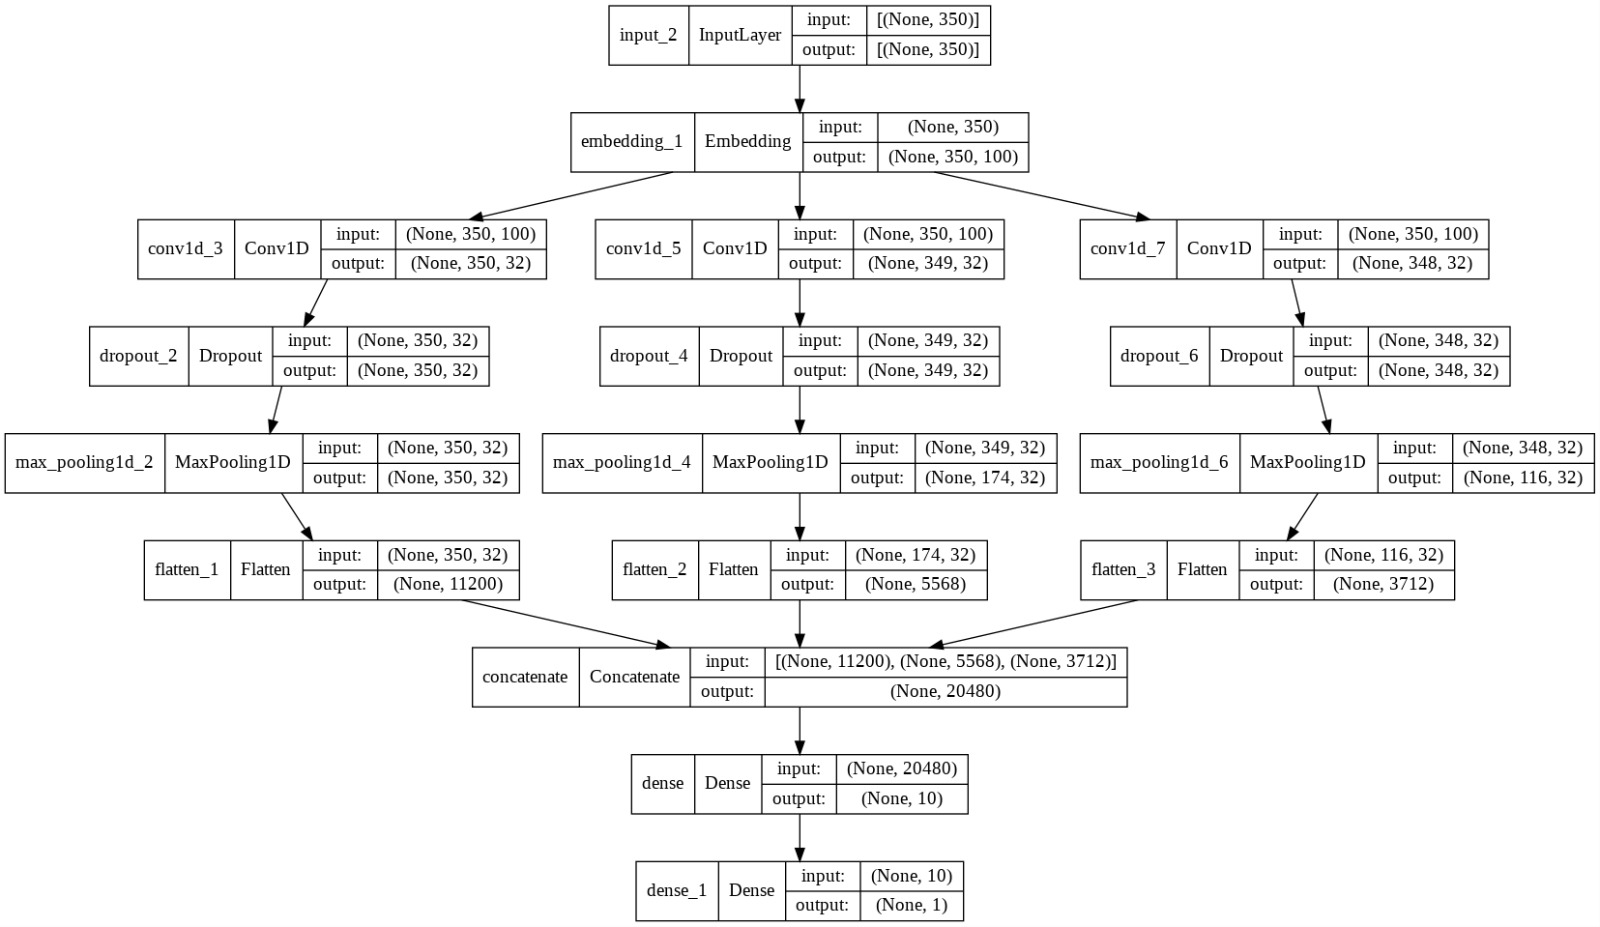

In [ ]:
# define the model
def define_model(length, vocab_size, word_embeddings_dimension, W, L):
	channel_outputs = []
	input=Input(shape=(length,))
	embedding = Embedding(vocab_size, word_embeddings_dimension)(input)
	for i in range(W):
		input_layer = embedding
		for j in range(L):
			conv = Conv1D(filters=32, kernel_size=i+1, activation='relu')(input_layer)

			input_layer = Dropout(0.5)(conv)

		pool = MaxPooling1D(pool_size=i+1)(input_layer)
	 
		flatten = Flatten()(pool)	 
		channel_outputs.append(flatten)

	# # merge
	merged = concatenate(channel_outputs)
	# interpretation
	dense1 = Dense(10, activation='relu')(merged)
	dense2 = Dense(10, activation='relu')(dense1)
	outputs = Dense(1, activation='sigmoid')(dense2)
	model = Model(input, outputs=outputs)
	# compile
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	# summarize
	return model

In [ ]:
model = define_model(350,10000, 150, 4, 3)
plot_model(model, show_shapes=True, to_file='define_model.png')	

In [ ]:
model.fit(train_data, train_labels, epochs=5, batch_size=32)

Epoch 1/5
1000/1000 [==============================] - 124s 123ms/step - loss: 0.4072 - accuracy: 0.7942
Epoch 2/5
1000/1000 [==============================] - 121s 121ms/step - loss: 0.2161 - accuracy: 0.9163
Epoch 3/5
1000/1000 [==============================] - 119s 119ms/step - loss: 0.1614 - accuracy: 0.9394
Epoch 4/5
1000/1000 [==============================] - 122s 122ms/step - loss: 0.1243 - accuracy: 0.9526
Epoch 5/5
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0905 - accuracy: 0.9683


In [ ]:
results = model.evaluate(test_data, test_labels)
print(results)

313/313 [==============================] - 5s 15ms/step - loss: 0.3447 - accuracy: 0.8674
[0.3446902930736542, 0.8673999905586243]


In [ ]:
results = model.evaluate(validation_data, validation_labels)
print(results)

250/250 [==============================] - 4s 15ms/step - loss: 0.3483 - accuracy: 0.8631
[0.3483467400074005, 0.8631250262260437]


In [ ]:
!pip install scikeras
!pip install scipy

Defaulting to user installation because normal site-packages is not writeable

You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.



Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python38\python.exe -m pip install --upgrade pip' command.


In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

maximal_length = [350]
vocab_size = [10000]
word_embeddings_dimension = [150]
W = [2,3]
L = [2,3]

param_grid = dict(length=maximal_length, vocab_size=vocab_size, word_embeddings_dimension=word_embeddings_dimension, W=W, L=L)
keras_model = KerasClassifier(model = define_model, length=350, vocab_size=10000, word_embeddings_dimension=150, W=2, L=2, verbose=1)

grid = GridSearchCV(keras_model,param_grid, scoring='accuracy', verbose=1, cv=5)
grid.fit(train_data, train_labels)

print(grid.best_score_, grid.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
1000/1000 [==============================] - 91s 91ms/step - loss: 0.6932 - accuracy: 0.4972
0.7806875 {'L': 3, 'W': 3, 'length': 350, 'vocab_size': 10000, 'word_embeddings_dimension': 150}


# Concluding Remarks

In the assignment, first we did the "vanilla" architecture or the model which resulted in a very low accuracy while trainning the model, meaning that the model is not optimized enough. Therefore the optimization step is required according also to the assignment requiments.

For the optimization process of the model architecure, we've done the Grid Search using the Meta-parameters, Hyper-parameters range as required in the assignment. we started with including all the possible parameter's values, however that meant that it will do all the permutation of these values which meant a very long execution time while using our machines capacities. Therefore we tried manually fitting the model with individual parameters ranges to see how the accuracy response to these changes.

Specifically, we saw that for the parameter word embedding dimensions, the best value was 150 while increasing it resulted in decreasing the model accuracy. for maximum length of each review sequence we used the value 350 as it resulted in the best accuracy. After we tried also individually changing the range for L and W, we saw that the values W=3 and L=3 gave us the best accuracy and to have this evaluated as the optimal values for our model, we tried Grid-Search with only 2 possible values for W and L ([2,3] respectively) which enabled us to have a minimized execution time to see some tangible results. 

The results of the Grid-Search optimization with such values, complied with best accuracy we reached while fitting the model manually with specific individual parameters. 
Finally, we tried Grid-Search optimization with all the possible values for the parameters but that resulted in a long execution time .

Ps: the proof is shown in the image below.

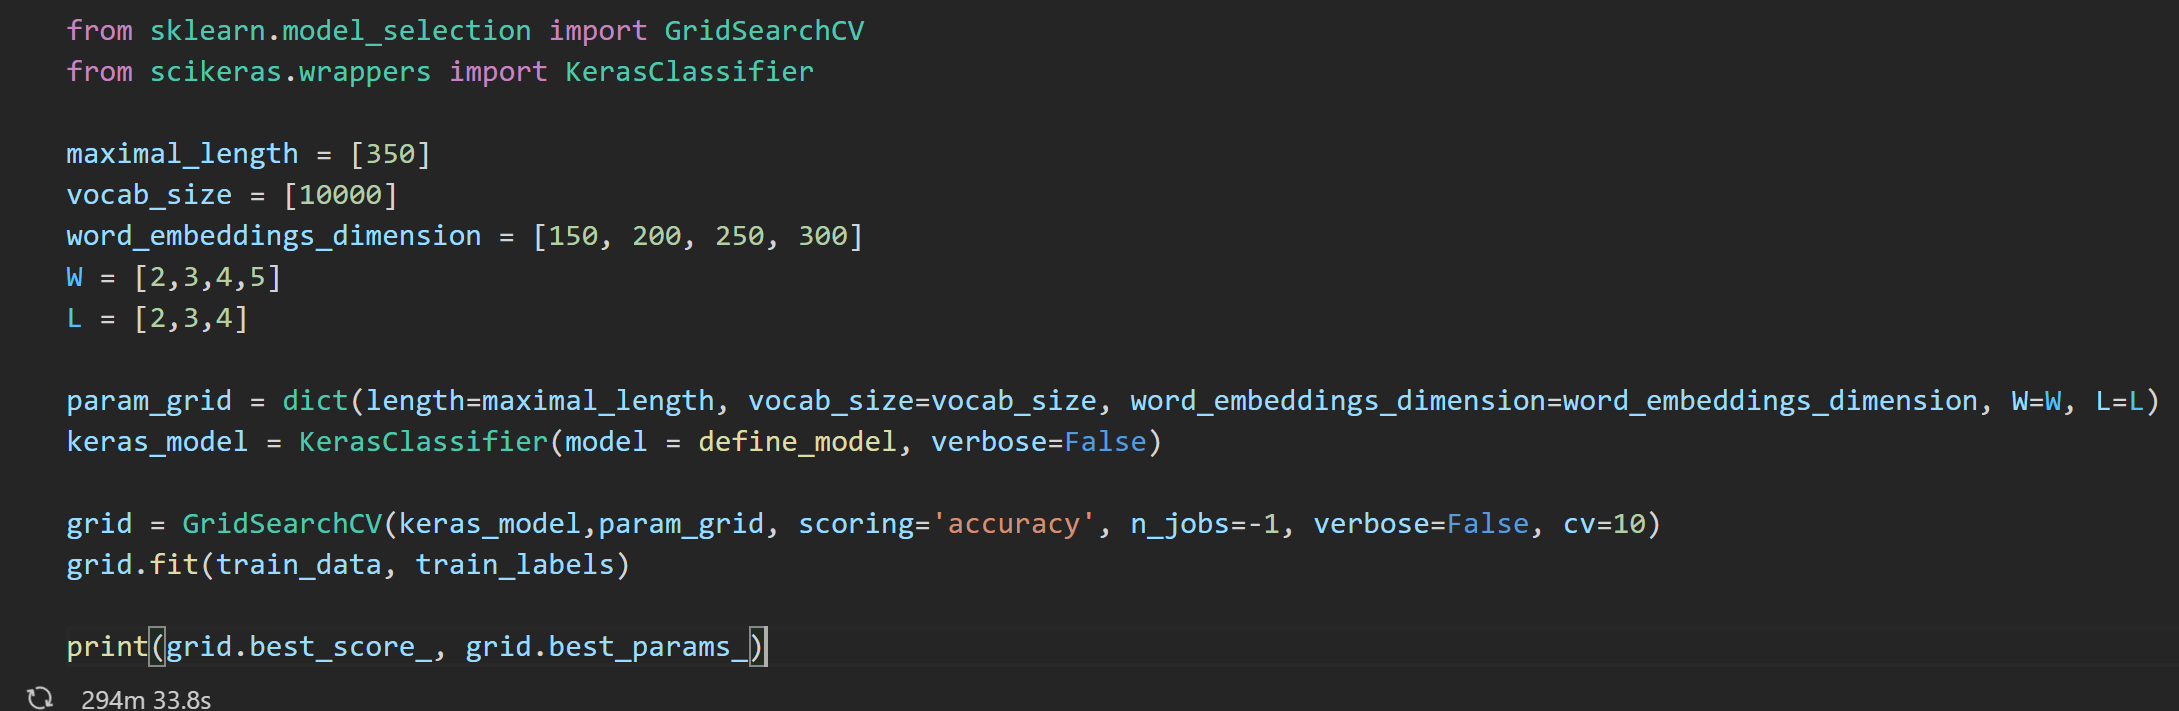